In [3]:
# MSc Project: Biometric Security - Baseline Model
## Author: Stella Williams
## Date: 04.10.2025

# Step 1: Load Pretrained FaceNet Model

import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Using device: cpu


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [4]:
# Step 2: Load & Filter LFW Dataset (e.g. 5 identities)
# Path to dataset
lfw_path = '/Users/stel/Documents/Dissertation/msc-biometric-security/Datasets/lfw-dataset'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# Load full dataset
lfw_full = datasets.ImageFolder(root=lfw_path, transform=transform)

# Pick 5 identities only (simulate SME-scale)
target_classes = random.sample(lfw_full.classes, 5)
print("Selected classes:", target_classes)

# Filter indices
target_indices = [i for i, (_, label) in enumerate(lfw_full) if lfw_full.classes[label] in target_classes]
lfw_subset = Subset(lfw_full, target_indices)
lfw_loader = DataLoader(lfw_subset, batch_size=1, shuffle=True)


Selected classes: ['Chen_Tsai-chin', 'Lesley_Coppin', 'George_Ryan', 'Alan_Zemaitis', 'Robert_Mueller']


In [5]:
# Step 3: FGSM Attack

import torch.nn as nn

# Loss and epsilon
criterion = nn.CosineEmbeddingLoss()
epsilon = 0.05

def fgsm_attack(image, gradient, eps):
    # Sign of gradient
    sign = gradient.sign()
    return torch.clamp(image + eps * sign, 0, 1)

# Get a sample
image, label = next(iter(lfw_loader))
image, label = image.to(device), label.to(device)

# Enable gradient
image.requires_grad = True

# Get embedding of true image
embedding_orig = model(image)

# Create "true" target for cosine loss (match itself)
target = torch.tensor([1.0]).to(device)

# Compute loss
loss = criterion(embedding_orig, embedding_orig.detach(), target)
model.zero_grad()
loss.backward()

# FGSM
perturbed_image = fgsm_attack(image, image.grad.data, epsilon)

# Evaluate perturbed embedding
embedding_adv = model(perturbed_image)

# Cosine similarity
cos = nn.CosineSimilarity(dim=1)
sim = cos(embedding_orig, embedding_adv).item()
print(f"Cosine similarity between clean and adversarial: {sim:.4f}")


Cosine similarity between clean and adversarial: 1.0000


In [8]:

# Step 4: Defence via JPEG Compression (Fixed)
import cv2
from PIL import Image

def jpeg_defence(img_tensor, quality=50):
    # Detach from computation graph
    img_np = img_tensor.detach().squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)

    # Save to JPEG in memory
    _, encoded = cv2.imencode('.jpg', img_np, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decoded = cv2.imdecode(encoded, cv2.IMREAD_COLOR)

    # Convert back to tensor
    recovered = transforms.ToTensor()(Image.fromarray(cv2.cvtColor(decoded, cv2.COLOR_BGR2RGB)))
    return recovered.unsqueeze(0).to(device)

# Apply defence
jpeg_image = jpeg_defence(perturbed_image)

# Evaluate similarity again
embedding_jpeg = model(jpeg_image)
sim_defended = cos(embedding_orig, embedding_jpeg).item()
print(f"Cosine similarity (clean vs. JPEG-recovered): {sim_defended:.4f}")


Cosine similarity (clean vs. JPEG-recovered): 0.8671


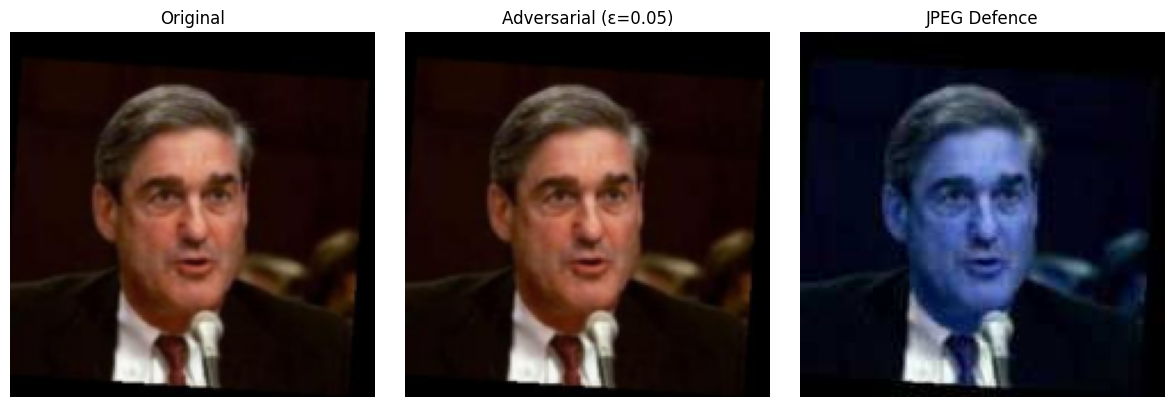

In [10]:
# Step 5: Visualise Images
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img.detach().squeeze().permute(1, 2, 0).cpu())
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(
    [image, perturbed_image, jpeg_image],
    ['Original', f'Adversarial (ε={epsilon})', 'JPEG Defence']
)
